# Face classification with Ango and Layer

## Install Ango

In [ ]:
!pip install ango -qqq

## Install Layer

In [2]:
!pip install --upgrade layer -qqq

## Fetch [data from Ango Hub](https://ango.ai/open-dataset/)

In [ ]:
from ango.sdk import SDK
import os 
import urllib.request

class Ango:
    def __init__(self, api_key, project_id=None) -> None:
        self.sdk = SDK(api_key=api_key)
        if project_id:
            self.project_id = project_id
    
    def setProject(self,project_id):
        self.project_id = project_id
    
    '''
    Gets annotations for assets within a project, streams page by page.
    params:
    items_per_page : The number of annotations fetched per page.
    annotation_status : The current stage of annotation ("Completed" OR "Todo") leave blank to fetch all

    returns:
    A List of annotations
    '''
    def getAnnotations(self, items_per_page = 100, annotation_status = None):
        remaining_tasks = 1
        page = 1
        tasks = []
        while (remaining_tasks > 0):
            response =  self.sdk.get_tasks(self.project_id, page=page, limit=items_per_page, status= annotation_status)
            tasks.extend(response['data']['tasks'])
            remaining_tasks =  response["data"]["total"] - len(tasks)
            page += 1
        return tasks

    def get_name_from_url(self, imgUrl):
      return imgUrl.split('/')[-1]

    def fetchImages(self,images, folder_path="downloaded_images/"):
      dirname = os.path.dirname(__file__)
      if (not os.path.exists(folder_path)):
          os.mkdir(os.path.join(dirname, folder_path))
      for imgUrl in images:
        img_name = self.get_name_from_url(imgUrl)
        image_path = os.path.join(dirname, folder_path, img_name)
        if os.path.isfile(image_path):
          continue
        else:
          urllib.request.urlretrieve(imgUrl, image_path)
      print("All images downloaded")

    def fetchExportLink(self):
      return self.sdk.export(self.project_id)['data']['exportPath']
      

In [ ]:

#Run this block after the two credentials have been added.
#You may save the annotations in JSON, or use them programatically. 
#Note: This takes some time for larger annotations.
ango = Ango(api_key="YOUR_API_KEY",project_id="YOUR_PROJECT_ID") #Face Classification
annotations = ango.getAnnotations(annotation_status="Completed")
print(len(annotations))


In [ ]:
link = ango.fetchExportLink()
print(link)

### Save the data as a Pandas DataFrame

In [ ]:
import pandas as pd
import io
import base64

def get_answer(schemaId, task):
  return next((answer["answer"] for answer in task['answer']['classifications'] if answer['schemaId'] == schemaId), None)

def build():
  from PIL import Image
  import requests

  data = []
  for task in annotations[:2500]:
    img_url = task["asset"]["data"]
    img = Image.open(requests.get(img_url, stream=True).raw)
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format=img.format)
    image_as_string = base64.b64encode(img_byte_arr.getvalue())
    img_str = image_as_string.decode("utf-8")

    data.append([
      img_str,
      get_answer("7d4d70ea16e8e5d7ce8e721", task), # Sex
      get_answer("76e4a3dbf96926edadd5203", task), # Age
      get_answer("05e865541776c186f3e4003", task), # Hair Color
      get_answer("ff5e7ac66607ebe73810601", task), # Beard Color
      get_answer("1f5411a7bbcdba28fe30677", task), # Mustache Color
      get_answer("d0d75fc06feaa006e5c0106", task), # Eye Color
      get_answer("ec5e7cd3838fc4d5c7c6298", task), # Glasses
    ])
    # answers = task['answer']['classifications']
    # answer = next((answer for answer in task['answer']['classifications'] if answer['schemaId'] == "7d4d70ea16e8e5d7ce8e721"), None)
    # print(answer)
    task['answer']['classifications']
  
  return pd.DataFrame(data,columns=["image", "sex", "age","hair_color","beard_color","mustache_color","eye_color","glasses"])

df = build()
df.head(1)

In [4]:
df.head()

,image,sex,age,hair_color,beard_color,mustache_color,eye_color,glasses
0,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,944d236620a51952c5e5571,ce831ed469ea6e878be9513,fc277c228c78e2205589549,34c35efb4914475c2ff3057,38f72fe7c936801c4f57923,97f0074a4016d00ba6ad145,d71a761292c505e31420704
1,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,193cda8ce1e759a6707f873,ce831ed469ea6e878be9513,fc277c228c78e2205589549,6919425e2396b9b40f6f485,b411a018af74c13ecf90737,840281fa1c0e97d6e2f5869,d71a761292c505e31420704
2,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,944d236620a51952c5e5571,ce831ed469ea6e878be9513,a5d5d80e66f9f205071a314,34c35efb4914475c2ff3057,38f72fe7c936801c4f57923,840281fa1c0e97d6e2f5869,d71a761292c505e31420704
3,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,944d236620a51952c5e5571,ce831ed469ea6e878be9513,fc277c228c78e2205589549,34c35efb4914475c2ff3057,38f72fe7c936801c4f57923,840281fa1c0e97d6e2f5869,d71a761292c505e31420704
4,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,193cda8ce1e759a6707f873,af9c38362173fccfd7c3015,a5d5d80e66f9f205071a314,34c35efb4914475c2ff3057,38f72fe7c936801c4f57923,840281fa1c0e97d6e2f5869,d71a761292c505e31420704


In [5]:
df['sex'].unique()

array(['944d236620a51952c5e5571', '193cda8ce1e759a6707f873',
       '77fd6146bfcfd5bfccba368'], dtype=object)

In [12]:
gender = df[['image','sex']]

In [13]:
gender.head()

,image,sex
0,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,944d236620a51952c5e5571
1,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,193cda8ce1e759a6707f873
2,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,944d236620a51952c5e5571
3,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,944d236620a51952c5e5571
4,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,193cda8ce1e759a6707f873


## Label encode the gender column 
We'll build a model to predict the gender of a person.

In [14]:
# creating instance of labelencoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
gender = gender.assign(sex = labelencoder.fit_transform(gender["sex"]))

In [15]:
gender.head()

,image,sex
0,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,2
1,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,0
2,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,2
3,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,2
4,iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAA...,0


In [16]:
gender['sex'].unique()

array([2, 0, 1])

### Split the data into a training and testing set

In [17]:
from sklearn.model_selection import train_test_split
X = gender[['image']]
y = gender[['sex']]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

### Process the image data

In [18]:
from PIL import Image
import io
import base64
from tensorflow.keras.preprocessing.image import img_to_array

def load_process_images(image):
    image_decoded = base64.b64decode(image)
    image = Image.open(io.BytesIO(image_decoded)).resize([224, 224])
    image = img_to_array(image)
    return image

In [19]:
import numpy as np
X_train = np.stack(X_train['image'].map(load_process_images))
X_test = np.stack(X_test['image'].map(load_process_images))

## Log in to Layer

In [ ]:
import layer
layer.login()

### Initialize a Layer project

In [ ]:
from layer.decorators import model, fabric
layer.init("ango-face-classification")

### Define the model training function

In [94]:
@fabric("f-gpu-small")
@model("face-classification")
def train():
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras.callbacks import EarlyStopping
  import matplotlib.pyplot as plt 
  from PIL import Image
  import numpy as np
  import pandas as pd
  for image in range(4):
    PIL_image = Image.fromarray(np.uint8(X_test[image])).convert('RGB')
    layer.log({f"Sample face-{image}": PIL_image})
    
  train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2,zoom_range=0.2, horizontal_flip=True,width_shift_range=0.1,height_shift_range=0.1)
  train_datagen.fit(X_train)
  training_data = train_datagen.flow(X_train, y_train, batch_size=32)
  validation_gen = ImageDataGenerator(rescale=1./255)
  image_size = (200, 200)
  testing_data = validation_gen.flow(X_test, y_test, batch_size=32)
  model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),  input_shape = (224, 224, 3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(3, activation='softmax')])
  model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])
  callback = EarlyStopping(monitor='loss', patience=3)
  epochs=2
  history = model.fit(training_data,validation_data=testing_data, epochs=epochs,callbacks=[callback])
  metrics_df = pd.DataFrame(history.history)
  layer.log({"metrics DataFrame": metrics_df})
  loss, accuracy = model.evaluate(testing_data)
  layer.log({"Testing loss": loss})
  layer.log({"Testing accuracy": accuracy})
  print('Accuracy on test dataset:', accuracy)
  metrics_df[["loss","val_loss"]].plot()
  layer.log({"Loss plot": plt.gcf()})
  training_loss, training_accuracy = model.evaluate(training_data)
  layer.log({"Training loss": loss})
  layer.log({"Training accuracy": accuracy})
  metrics_df[["categorical_accuracy","val_categorical_accuracy"]].plot()
  layer.log({"Accuracy plot": plt.gcf()})
  return model

### Model training

In [50]:
# Train the model on your local infra
train()

In [ ]:
# Run the project on Layer Infra using remote GPUs
layer.run([train])

### Fetch trained model

In [71]:
my_model = layer.get_model('layer/ango-face-classification/models/face-classification').get_train()

⠦  face-classification  ━━━━━━━━━━ LOADED [0:00:00]

### Run predictions on the model

In [ ]:
import numpy as np
from keras.preprocessing import image

In [72]:
test_image = X_test[0]

In [73]:
test_image_array = np.expand_dims(test_image, axis=0)
prediction = my_model.predict(test_image_array)

2022-05-16 11:31:17.768274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [74]:
prediction

array([[9.748167e-22, 0.000000e+00, 1.000000e+00]], dtype=float32)

In [75]:
import tensorflow as tf
scores = tf.nn.softmax(prediction[0])
scores = scores.numpy()
class_names = [0,1,2]
f"{class_names[np.argmax(scores)]} with a { (100 * np.max(scores)).round(2) } percent confidence." 

'2 with a 57.61 percent confidence.'

In [76]:
type(X_test[0])

numpy.ndarray

In [77]:
from PIL import Image
import numpy as np
PIL_image = Image.fromarray(np.uint8(X_test[0])).convert('RGB')

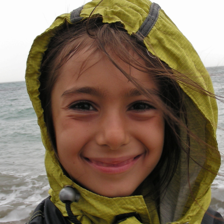

In [78]:
PIL_image

In [ ]:
!wget --no-check-certificate \
   https://storage.googleapis.com/ango-covid-dataset/ffhq-dataset/batch2/48312.png \
    -O 48312.png

In [80]:
test_image = image.load_img('48312.png', target_size=(224, 224))

In [81]:
test_image = image.img_to_array(test_image)

In [82]:
test_image = test_image / 255.0

In [83]:
test_image = np.expand_dims(test_image, axis=0)

In [84]:
prediction = my_model.predict(test_image)

In [87]:
prediction[0]

array([0.994645  , 0.00109425, 0.00426078], dtype=float32)

In [86]:
import tensorflow as tf
scores = tf.nn.softmax(prediction[0])
scores = scores.numpy()
class_names = [0,1,2]
f"{class_names[np.argmax(scores)]} with a { (100 * np.max(scores)).round(2) } percent confidence." 

'0 with a 57.42 percent confidence.'

In [89]:
list(labelencoder.inverse_transform([0,1,2]))

['193cda8ce1e759a6707f873',
 '77fd6146bfcfd5bfccba368',
 '944d236620a51952c5e5571']

## Next steps
To learn more about using layer, you can: 
- Join our [Slack Community ](https://bit.ly/layercommunityslack)
- Visit [Layer Examples Repo](https://github.com/layerai/examples) for more examples
- Browse [Trending Layer Projects](https://layer.ai) on our mainpage
- Check out [Layer Documentation](https://docs.app.layer.ai) to learn more